In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# read in all the words
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
print(len(words), "names in total")
# take a look at some names
print(max(len(w) for w in words))
print(words[:10])

32033 names in total
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [12]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [13]:
# Shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [14]:
# build the dataset
block_size = 3 # how many characters to predict
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print("Training set size:", Xtr.shape[0])
print("Validation set size:", Xdev.shape[0])
print("Test set size:", Xte.shape[0])

Training set size: 182625
Validation set size: 22655
Test set size: 22866


In [15]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[i.item()] for i in x), '->', itos[y.item()])

... -> y
..y -> u
.yu -> h
yuh -> e
uhe -> n
hen -> g
eng -> .
... -> d
..d -> i
.di -> o
dio -> n
ion -> d
ond -> r
ndr -> e
dre -> .
... -> x
..x -> a
.xa -> v
xav -> i
avi -> e


In [16]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (not trained with backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [17]:
torch.manual_seed(42); # seed rng for reproducibility

In [20]:
n_embd = 10 # size of embedding vector
n_hidden = 200 # size of hidden layer

C = torch.randn((vocab_size, n_embd)) # embedding matrix
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # the last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]  
print("Number of parameters:", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Number of parameters: 12097


In [21]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # flatten the batch
  for layer in layers:
    x = layer(x) # apply the layers
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3065
  10000/ 200000: 2.3348
  20000/ 200000: 1.9664
  30000/ 200000: 2.2255
  40000/ 200000: 2.2540
  50000/ 200000: 1.6943
  60000/ 200000: 2.0700
  70000/ 200000: 1.9204
  80000/ 200000: 2.4701
  90000/ 200000: 2.3120
 100000/ 200000: 1.7667
 110000/ 200000: 2.5395
 120000/ 200000: 2.3391
 130000/ 200000: 2.1354
 140000/ 200000: 2.2176
 150000/ 200000: 2.2406
 160000/ 200000: 2.1028
 170000/ 200000: 1.5642
 180000/ 200000: 1.8046
 190000/ 200000: 2.1677


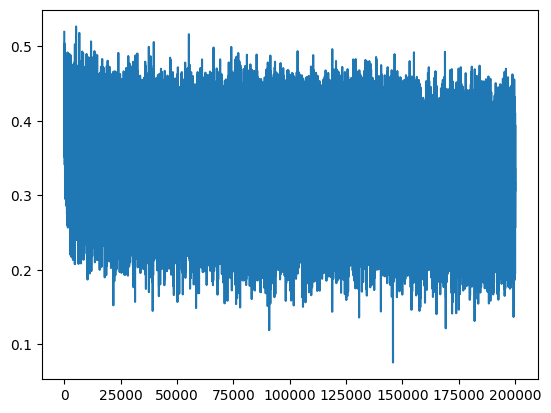

In [22]:
plt.plot(lossi)

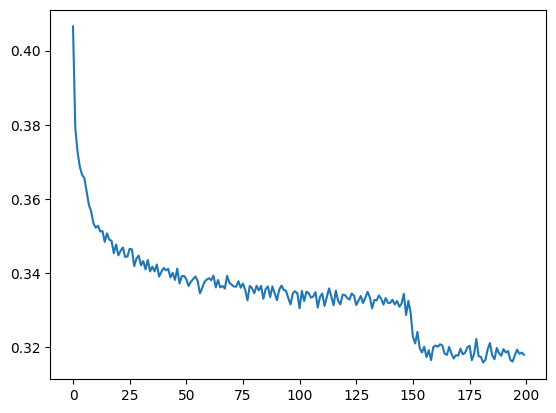

In [30]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [23]:
 # put layers in eval mode (needed for batch norm)
for layer in layers:
    layer.training = False

In [24]:
# evaluate the loss 
@torch.no_grad() # no need to track gradients
def split_loss(X, Y):
    emb = C[X] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # flatten the batch
    for layer in layers:
        x = layer(x) # apply the layers
    loss = F.cross_entropy(x, Y) # loss function
    return loss
print("Train set loss:", split_loss(Xtr, Ytr).item())
print("Validation set loss:", split_loss(Xdev, Ydev).item())
print("Test set loss:", split_loss(Xte, Yte).item())

Train set loss: 2.0613901615142822
Validation set loss: 2.1090986728668213
Test set loss: 2.1068291664123535


In [28]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x) # apply the layers
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        if ix == 0: break # stop at the end of the word
        out.append(itos[ix])
        context = context[1:] + [ix]
    print(''.join(out))

sophil
wahim
dordythanelle
nouroley
fina
zaleigh
maelalli
maenaney
ney
drediz
cathizaneem
ariah
avii
mercto
ole
xynn
lis
malebhzokuma
ersaelyn
leon
